In [1]:
cd /media/sharukathirimanne/OS/Users/Sharuka Thirimanne/Desktop/FYP-ML-IDS

/media/sharukathirimanne/OS/Users/Sharuka Thirimanne/Desktop/FYP-ML-IDS


In [2]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import Model, layers
from sklearn.model_selection import cross_val_score
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix,f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# Pipeline Saving
from pickle import dump
from io import StringIO
import joblib
from keras.models import model_from_json
import json

import datetime


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

# ML Model Training

In [5]:
def train_preprocess():
    df_train = pd.read_csv('Datasets/csv_result-KDDTrain+.csv')
    df_train.drop(['id'], axis = 'columns' , inplace = True)
    
    col_list = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
                'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
                'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','class']
    
    df_train = df_train[col_list]
    
    #for i in range(11,20):
        #df_train.drop(df_train.columns[i],axis='columns',inplace=True)
        
    num_features = len(df_train.columns) - 1
    print('Number of features before feature selection :',num_features)
    print('Original dataset duplicates :',df_train.duplicated().sum())

    num_features = len(df_train.columns) - 1
    print('Number of features after feature selection :',num_features)
    print('Duplicates after feature selection :',df_train.duplicated().sum())
    for col in ['protocol_type','flag','service']:
        df_train[col] = df_train[col].astype('category')
    
    label1 = 'Other_service'
    others1 = df_train['service'].value_counts().index[30:]
    df_train['service'] = df_train['service'].cat.add_categories([label1])
    df_train['service'] = df_train['service'].replace(others1, label1)

    df_train['service'].replace({'time':'Other_service','urp_i':'Other_service',
                                 'csnet_ns':'Other_service','supdup':'Other_service',
                                 'discard':'Other_service','http_443':'Other_service'}, inplace = True)
    
    print('Duplicates after category reduction :',df_train.duplicated().sum())
    df_train['class'] = df_train['class'].map( {'normal':0, 'anomaly':1} )
    df_train.drop_duplicates(keep='first',inplace=True)
    print('Duplicates after duplicate drop :',df_train.duplicated().sum())
    df_train.reset_index(drop=True,inplace=True)
    
    return df_train
df_train = train_preprocess()

Number of features before feature selection : 28
Original dataset duplicates : 27
Number of features after feature selection : 28
Duplicates after feature selection : 27
Duplicates after category reduction : 1486
Duplicates after duplicate drop : 0


In [6]:
print(df_train['protocol_type'].value_counts())
print('======================================')
print(df_train['service'].value_counts())
print('======================================')
print(df_train['flag'].value_counts())

tcp     101212
udp      14993
icmp      8282
Name: protocol_type, dtype: int64
http             40332
private          21853
Other_service    12075
domain_u          9043
smtp              7313
ftp_data          6848
eco_i             4582
other             4359
ecr_i             3072
telnet            2353
finger            1767
ftp               1754
auth               955
Z39_50             862
uucp               780
courier            734
bgp                710
whois              693
uucp_path          689
iso_tsap           687
imap4              647
nnsp               630
vmnet              617
domain             569
ctf                563
Name: service, dtype: int64
SF        74918
S0        33653
REJ       11058
RSTR       2389
RSTO       1527
S1          365
SH          252
S2          127
RSTOS0      103
S3           49
OTH          46
Name: flag, dtype: int64


In [7]:
df_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [8]:
df_train.shape

(124487, 29)

In [9]:
limit1 = df_train.shape[1]-1
    
X_train = df_train.iloc[:,0:limit1] # train set features
y_train = df_train.iloc[:,limit1]

In [10]:
df_train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [11]:
categorical_cols = ['protocol_type','flag','service']
std_cols = ['duration','src_bytes','dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count','serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate','same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
            'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate',
            'dst_host_rerror_rate','dst_host_srv_rerror_rate']

In [12]:
X_train.shape

(124487, 28)

In [13]:
ohe = OneHotEncoder()
std_scaler = StandardScaler()

columnTransformer = make_column_transformer(
    ( ohe, categorical_cols),
    (std_scaler,std_cols), 
    remainder='passthrough')

X_train = columnTransformer.fit_transform(X_train)

In [14]:
X_train.shape

(124487, 64)

In [15]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [16]:
init_sigmoid = tf.keras.initializers.GlorotUniform()
init = tf.keras.initializers.HeUniform()

#Neural Network Model
model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer=init, bias_initializer='zeros', input_dim=64))

model.add(Dense(160, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(352, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(320, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(448, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(384, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(192, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(224, activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))
model.add(Dense(32 , activation='relu', kernel_initializer=init, bias_initializer='zeros'))


model.add(Dense(1, activation='sigmoid', kernel_initializer=init_sigmoid, bias_initializer='zeros'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = 0.001),metrics = METRICS)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x=X_train, y=y_train, epochs=100, validation_split=0.25, 
                    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/100
2918/2918 [==============================] - 27s 5ms/step - loss: 0.2876 - accuracy: 0.8506 - precision: 0.8804 - recall: 0.7586 - auc: 0.8385 - val_loss: 0.0766 - val_accuracy: 0.9559 - val_precision: 0.9640 - val_recall: 0.9392 - val_auc: 0.9860
Epoch 2/100
2918/2918 [==============================] - 15s 5ms/step - loss: 0.0686 - accuracy: 0.9613 - precision: 0.9699 - recall: 0.9451 - auc: 0.9888 - val_loss: 0.0491 - val_accuracy: 0.9687 - val_precision: 0.9775 - val_recall: 0.9538 - val_auc: 0.9927
Epoch 3/100
2918/2918 [==============================] - 15s 5ms/step - loss: 0.0434 - accuracy: 0.9709 - precision: 0.9795 - recall: 0.9566 - auc: 0.9937 - val_loss: 0.0355 - val_accuracy: 0.9748 - val_precision: 0.9820 - val_recall: 0.9627 - val_auc: 0.9952
Epoch 4/100
2918/2918 [==============================] - 15s 5ms/step - loss: 0.0360 - accuracy: 0.9761 - precision: 0.9827 - recall: 0.9649 - auc: 0.9957 - val_loss: 0.0318 - val_accuracy: 0.9784 - val_precision: 0.9842

2918/2918 [==============================] - 14s 5ms/step - loss: 0.0086 - accuracy: 0.9939 - precision: 0.9947 - recall: 0.9921 - auc: 0.9995 - val_loss: 0.0195 - val_accuracy: 0.9940 - val_precision: 0.9947 - val_recall: 0.9921 - val_auc: 0.9996
Epoch 64/100
2918/2918 [==============================] - 14s 5ms/step - loss: 0.0088 - accuracy: 0.9940 - precision: 0.9947 - recall: 0.9921 - auc: 0.9995 - val_loss: 0.0179 - val_accuracy: 0.9940 - val_precision: 0.9947 - val_recall: 0.9922 - val_auc: 0.9996
Epoch 65/100
2918/2918 [==============================] - 14s 5ms/step - loss: 0.0093 - accuracy: 0.9940 - precision: 0.9948 - recall: 0.9922 - auc: 0.9995 - val_loss: 0.0162 - val_accuracy: 0.9940 - val_precision: 0.9948 - val_recall: 0.9922 - val_auc: 0.9996
Epoch 66/100
2918/2918 [==============================] - 15s 5ms/step - loss: 0.0088 - accuracy: 0.9940 - precision: 0.9948 - recall: 0.9922 - auc: 0.9995 - val_loss: 0.0166 - val_accuracy: 0.9941 - val_precision: 0.9948 - val_re

In [17]:
weights, biases = model.layers[3].get_weights()

In [18]:
weights

array([[ 0.00875228,  0.04728261, -0.08395214, ..., -0.04712126,
        -0.06096795, -0.0579747 ],
       [ 0.1202461 ,  0.03864862, -0.11316293, ..., -0.0012112 ,
         0.0219023 , -0.09445686],
       [ 0.12631263, -0.00468325, -0.05771919, ..., -0.12266408,
         0.09231746,  0.02361496],
       ...,
       [-0.1066062 , -0.01253168,  0.12162158, ...,  0.04591535,
        -0.02291029, -0.08638179],
       [ 0.13158418,  0.04014952, -0.0014439 , ..., -0.10034792,
         0.10752542,  0.01601047],
       [ 0.08713535, -0.11672754,  0.10556512, ..., -0.04765926,
         0.03720725, -0.01865363]], dtype=float32)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 160)               10400     
_________________________________________________________________
dense_2 (Dense)              (None, 352)               56672     
_________________________________________________________________
dense_3 (Dense)              (None, 320)               112960    
_________________________________________________________________
dense_4 (Dense)              (None, 448)               143808    
_________________________________________________________________
dense_5 (Dense)              (None, 384)               172416    
_________________________________________________________________
dense_6 (Dense)              (None, 192)               7

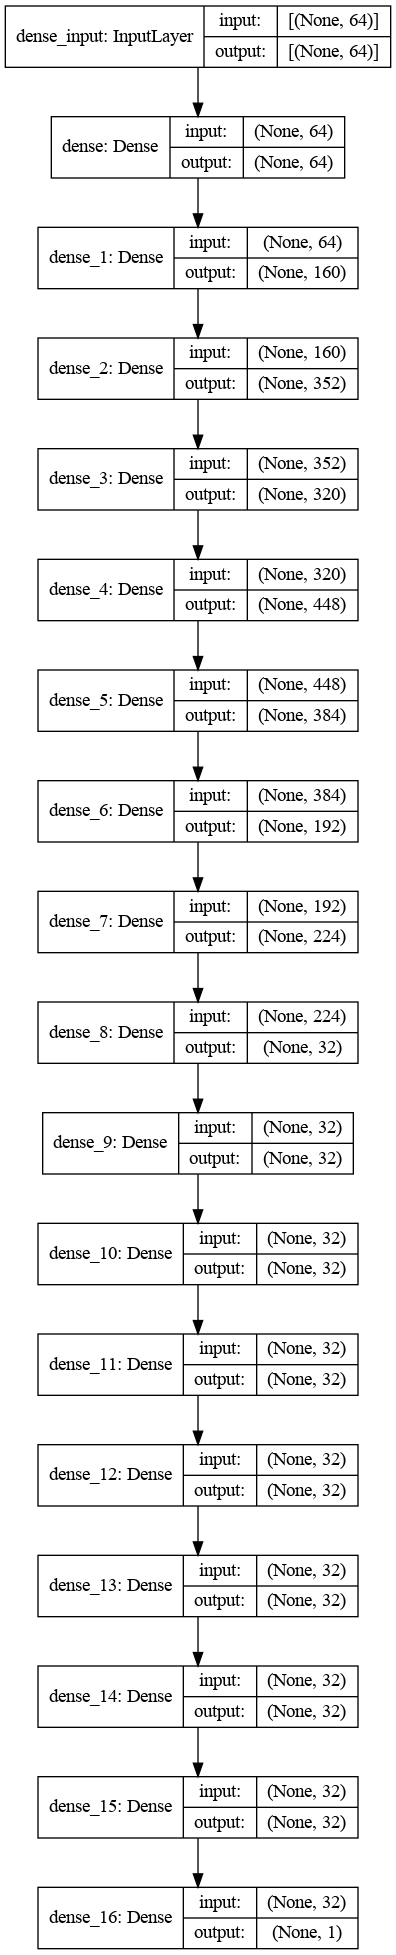

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

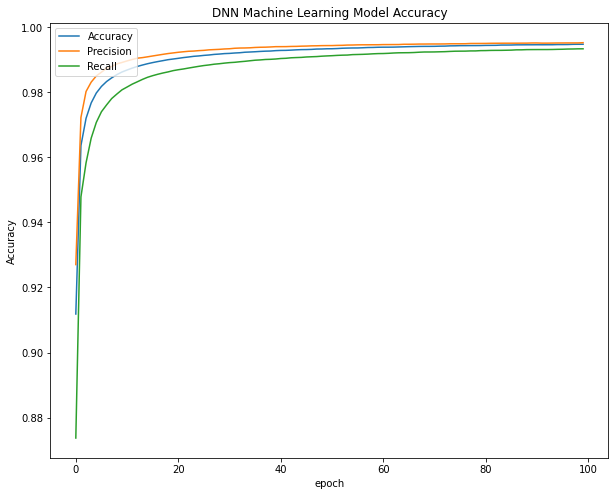

In [21]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.title('DNN Machine Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Precision','Recall'], loc='upper left')
plt.show()

In [22]:
%tensorboard --logdir logs/fit

# Testing 

In [23]:
def test_preprocess():
    df_test = pd.read_csv('Datasets/csv_result-KDDTest+.csv')
    df_test.drop(['id'], axis = 'columns' , inplace = True)
    
    #for i in range(11,20):
        #df_train.drop(df_train.columns[i],axis='columns',inplace=True)
        
    col_list = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
                'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
                'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
                'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','class']
    
    df_test = df_test[col_list]
        
    for col in ['protocol_type','flag','service']:
        df_test[col] = df_test[col].astype('category')
    
    label1 = 'Other_service'
    others1 = df_test['service'].value_counts().index[30:]
    # apply new category label
    df_test['service'] = df_test['service'].cat.add_categories([label1])
    df_test['service'] = df_test['service'].replace(others1, label1)

    print('Duplicates after category reduction :',df_test.duplicated().sum())
    df_test['service'].replace({'pop_3':'Other_service','sunrpc':'Other_service',
                                'link':'Other_service','name':'Other_service','echo':'Other_service',
                                'netbios_ns':'Other_service'}, inplace = True)
    
    df_test['class'] = df_test['class'].map( {'normal':0, 'anomaly':1} )
    df_test.drop_duplicates(keep='first',inplace=True)
    print('Duplicates after duplicate drop :',df_test.duplicated().sum())
    
    return df_test
df_test = test_preprocess()

Duplicates after category reduction : 44
Duplicates after duplicate drop : 0


In [24]:
print(df_test['protocol_type'].value_counts())
print('======================================')
print(df_test['service'].value_counts())
print('======================================')
print(df_test['flag'].value_counts())

tcp     18828
udp      2621
icmp     1043
Name: protocol_type, dtype: int64
http             7849
private          4774
Other_service    2040
telnet           1626
smtp              934
domain_u          894
other             835
ftp_data          833
ecr_i             752
ftp               692
imap4             306
eco_i             262
finger            136
auth               67
domain             51
uucp               50
iso_tsap           48
bgp                46
uucp_path          46
Z39_50             45
vmnet              43
nnsp               42
ctf                41
courier            40
whois              40
Name: service, dtype: int64
SF        14853
REJ        3839
S0         1996
RSTO        771
RSTR        669
S3          249
SH           73
S1           21
S2           15
OTH           4
RSTOS0        2
Name: flag, dtype: int64


In [25]:
df_test.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [26]:
len(df_test.columns)

29

In [27]:
limit2 = df_test.shape[1]-1
    
X_test = df_test.iloc[:,0:limit2] # train set features
Y_test = df_test.iloc[:,limit2]

In [28]:
X_test = columnTransformer.transform(X_test)

In [29]:
X_test.shape

(22492, 64)

In [30]:
test_predictions = model.predict(X_test)
test_predictions

array([[1.0000000e+00],
       [9.9999988e-01],
       [1.0042097e-04],
       ...,
       [3.9428473e-04],
       [4.0049559e-05],
       [1.0000000e+00]], dtype=float32)

In [31]:
print(np.unique(test_predictions))

[3.5364975e-13 4.1338753e-13 4.8121923e-13 ... 9.9999982e-01 9.9999988e-01
 1.0000000e+00]


In [32]:
test_predictions[5]

array([1.4959919e-05], dtype=float32)

In [33]:
rounded_test_predictions = []

for i, value in enumerate(test_predictions):
    if value > 0.5:
        rounded_test_predictions.append(1)
    else:
        rounded_test_predictions.append(0)
                

True Negatives  : 0.9732
False Positives : 0.0268
False Negatives : 0.3453
True Positives  : 0.6547


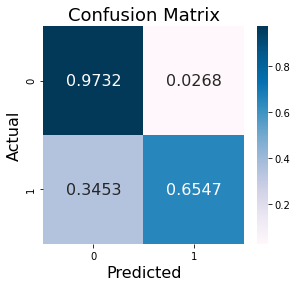

In [34]:
def plot_cm(labels, predictions, title = 'Confusion Matrix'):
    cm = confusion_matrix(labels, predictions, normalize= 'true')
    plt.figure(figsize=(4.5,4))
    sns.heatmap(cm, cmap= 'PuBu', annot=True, fmt='.4f', annot_kws=    {'size':16})
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title(title, fontsize=18)

    print('True Negatives  : {:.4f}'.format(cm[0][0]))
    print('False Positives : {:.4f}'.format(cm[0][1]))
    print('False Negatives : {:.4f}'.format(cm[1][0]))
    print('True Positives  : {:.4f}'.format(cm[1][1]))
    
plot_cm(Y_test,rounded_test_predictions)

In [35]:
print("Test set accuracy  : {:.4f}".format(accuracy_score(Y_test, rounded_test_predictions)))
print("Test set precision : {:.4f}".format(precision_score(Y_test, rounded_test_predictions)))
print("Test set recall    : {:.4f}".format(recall_score(Y_test, rounded_test_predictions)))
print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, rounded_test_predictions)))

Test set accuracy  : 0.7922
Test set precision : 0.9699
Test set recall    : 0.6547
Test set F1-score  : 0.7817


<ipython-input-36-129bfb7c9ca4>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


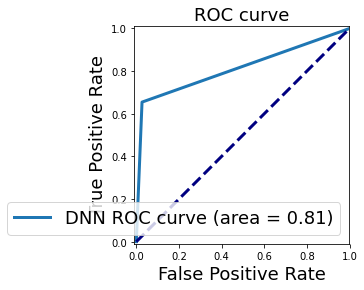

In [36]:
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(Y_test, rounded_test_predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='DNN ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

## Saving ML Model and OneHotEncoder/StandardScaler

In [37]:
# saving model
json_model = model.to_json()
open('DNN_Realtime_Model.json', 'w').write(json_model)
# saving weights
model.save_weights('DNN_model_weights.h5', overwrite=True)

In [38]:
joblib.dump(columnTransformer,"DNN_Realtime_ColumnTransformer")

['DNN_Realtime_ColumnTransformer']

# Hyperparameter Tuning - KerasTuner

In [24]:

def build_model(hp):
    init_tune = tf.keras.initializers.HeNormal()
    
    # Hyperparameters
    num_hidden_layers = hp.Int('num_hidden_layers',2,20)
    
    model_tune = keras.Sequential()
    
    #Input Layer
    model_tune.add(Dense(64, input_dim=64, activation='relu', 
                         kernel_initializer=init_tune, 
                         kernel_regularizer=l2(0.01), 
                         bias_regularizer=l2(0.01),
                         bias_initializer='zeros'))
    
    #Hidden Layers
    regularization_coef = hp.Choice('regularization_coef',values = [0.1,0.01,0.001,0.001])
    for i in range(num_hidden_layers):
        model_tune.add(Dense(units=hp.Int('num_neurons' + str(i),
                                          min_value = 32,
                                          max_value = 512,
                                          step = 32),
                             kernel_regularizer=l2(regularization_coef), 
                             bias_regularizer=l2(regularization_coef),
                             kernel_initializer=init_tune, bias_initializer='zeros',
                             activation = 'relu'))
        
    #Output Layer
    model_tune.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model_tune.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.SGD(learning_rate = learning_rate), 
                  metrics = METRICS)
    
    return model_tune


In [25]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='DNN_Realtime')

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
regularization_coef (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.001], 'ordered': True}
num_neurons0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_neurons1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [27]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.3)

Trial 5 Complete [00h 18m 13s]
val_accuracy: 0.9791237314542135

Best val_accuracy So Far: 0.9953409830729166
Total elapsed time: 02h 17m 48s
INFO:tensorflow:Oracle triggered exit


In [28]:
best_models = tuner.get_best_models(num_models=2)

In [29]:
tuner.results_summary()

Results summary
Results in my_dir/DNN_Realtime
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 5
regularization_coef: 0.001
num_neurons0: 192
num_neurons1: 288
learning_rate: 0.01
num_neurons2: 352
num_neurons3: 64
num_neurons4: 96
num_neurons5: 160
num_neurons6: 512
Score: 0.9953409830729166
Trial summary
Hyperparameters:
num_hidden_layers: 15
regularization_coef: 0.001
num_neurons0: 160
num_neurons1: 352
learning_rate: 0.001
num_neurons2: 320
num_neurons3: 448
num_neurons4: 384
num_neurons5: 192
num_neurons6: 224
num_neurons7: 32
num_neurons8: 32
num_neurons9: 32
num_neurons10: 32
num_neurons11: 32
num_neurons12: 32
num_neurons13: 32
num_neurons14: 32
Score: 0.9953052997589111
Trial summary
Hyperparameters:
num_hidden_layers: 7
regularization_coef: 0.1
num_neurons0: 224
num_neurons1: 352
learning_rate: 0.001
num_neurons2: 32
num_neurons3: 32
num_neurons4: 32
num_neurons5: 32
num_neurons6: 32
Score: 0.99411821365